## Topic discovery: yelp review

In [55]:
# from huggingface_hub import hf_hub_download 
import torch
from datasets import load_dataset, load_from_disk
import evaluate
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from peft import PeftConfig, PeftModel
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from huggingface_hub import notebook_login
from accelerate import init_empty_weights, load_checkpoint_and_dispatch, infer_auto_device_map, dispatch_model

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
import os
import glob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string

In [2]:
print(transformers.__version__)

4.35.2


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

def load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=True, **kwargs):
    """
    if use load_in_4bit=True, do not set to_device=True
    kwargs:
        - device_map
        - torch_dtype
        - load_in_4bit
    """
    if not os.path.isfile(model_path + '/tokenizer.json'):
        print('no existing tokenizer found. Download from HF')
        tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                  cache_dir=cache_dir,
                                                  **kwargs
                                                 ) # to load tokenizer to cache
    else:
        print('existing tokenizer found. Load from local')
        tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                                  cache_dir=cache_dir, 
                                                  local_flies_only=True)
    if not bool(glob.glob(model_path + '/model*.safetensors')):
        print('no existing model found. Download from HF')
        model = AutoModelForClass.from_pretrained(model_name,
                                                     cache_dir=cache_dir,
                                                     **kwargs
                                                    )
    else:
        print('existing model found. Load from local')
        model = AutoModelForClass.from_pretrained(model_path, 
                                                 cache_dir=cache_dir,
                                                 local_files_only=True)
    
    if to_device:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device.reset()
        model.to(device) # use GPU. Do not need this if using load_in_4bit as it's already been set to the correct devices
        
    return tokenizer, model

In [6]:
llm_repo_dir = 'D:/projects/LLM'
cache_dir = '/cygdrive/d/projects/LLM/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir + '/huggingface'
os.environ['XDG_CACHE_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [92]:
model_name = 'google-bert/bert-base-cased'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'

AutoModelForClass = AutoModelForSequenceClassification
to_device = True
tokenizer, model = load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=to_device)

existing tokenizer found. Load from local
existing model found. Load from local


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dataset_path = cache_dir + '/parquet/yelp_polarity' # cache_dir + '/parquet/yelp_review_full-e22176106d6e7534'
dataset_name = 'yelp_polarity' # yelp_review_full

if not os.path.isdir(dataset_path):
    dataset = load_dataset(dataset_name, cache_dir=cache_dir + '/parquet')
else:
    dataset = load_dataset(dataset_path)

In [8]:
tokenized_data_path = cache_dir + '/tokenized_dataset_yelp_polarity_bert'

tokenized_datasets = load_from_disk(tokenized_data_path)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [9]:
print(type(small_train_dataset))
print(small_train_dataset.shape)

<class 'datasets.arrow_dataset.Dataset'>
(1000, 5)


### use fine-tuned BERT for word embedding

In [10]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

In [11]:
ft_model_dir = cache_dir + '/ft_lora_yelp_polarity'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'
num_labels = 2
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=num_labels, 
                                                           cache_dir=cache_dir, 
                                                           local_files_only=True)
model_lora = PeftModel.from_pretrained(model_pretrained, ft_model_dir)
model_lora.to(device)
model_lora.eval()

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): Dropout(p=0.1, inplace=False)
                    (lora_A): Linear(in_features=768, out_features=50, bias=False)
                    (lora_B): Linear(in_features=50, out_features=768, bias=False)
    

In [12]:
%%time

#cls_embedding = torch.tensor([]).to('cuda')
cls_embedding_lora = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model_lora(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding_lora.append(output.hidden_states[-1][0,0,:].cpu().numpy())
cls_embedding_lora = np.array(cls_embedding_lora)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


CPU times: total: 29.4 s
Wall time: 1min 2s


D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


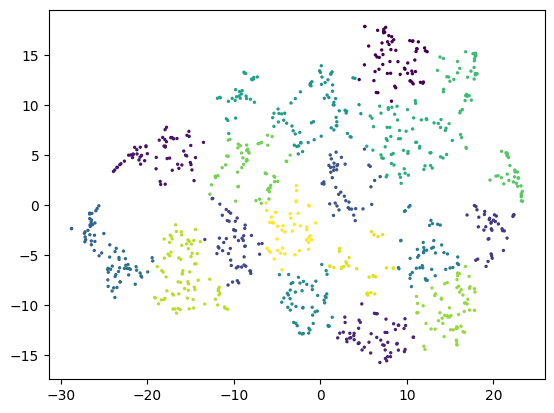

In [13]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=20, learning_rate=1, random_state=123))
                ])
cls_embedding_lora_tsne = pipe.fit_transform(cls_embedding_lora)
km_lora = KMeans(n_clusters=20)
km_lora.fit(cls_embedding_lora_tsne)

plt.scatter(cls_embedding_lora_tsne[:,0],
            cls_embedding_lora_tsne[:,1], 
            s=2,
            c=km_lora.labels_)

In [14]:
nonzero_token_length = (np.array(small_train_dataset['input_ids'])!=0).sum(axis=1)

df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'x':cls_embedding_lora_tsne[:,0],
                                      'y':cls_embedding_lora_tsne[:,1],
                                      'label':km_lora.labels_,
                                      'nonzero_token_length':nonzero_token_length,
                                      'sentiment':small_train_dataset['label']})

In [15]:
df_comment_from_label.groupby('label')[['nonzero_token_length', 'sentiment']].mean().sort_values('sentiment')

,nonzero_token_length,sentiment
label,,
2,161.982456,0.017544
16,249.936508,0.047619
3,395.736842,0.052632
9,120.634615,0.057692
14,504.030303,0.060606
8,269.102041,0.122449
18,151.551724,0.137931
4,76.961538,0.346154
19,108.533333,0.400000


In [16]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
2,57.0,0.017544,0.132453
16,63.0,0.047619,0.214669
3,38.0,0.052632,0.226294
9,52.0,0.057692,0.235435
14,33.0,0.060606,0.242306
8,49.0,0.122449,0.331201
18,29.0,0.137931,0.350931
4,52.0,0.346154,0.480384
19,45.0,0.400000,0.495434


In [18]:
df_comment_from_label

,comment,x,y,label,nonzero_token_length,sentiment
0,"Decent size, decent selection, decent staff.\n...",1.079186,0.119942,5,130,1
1,I have definitely experienced better! Let's se...,22.260588,-1.135423,3,465,0
2,Food is mediocre at best. I came in one day an...,-22.166599,-6.984957,7,38,0
3,Best casino in the PHX area.,-26.438360,-1.959146,6,11,1
4,This place is a must try! Truly a fan of Skinn...,7.765141,16.327570,0,206,1
...,...,...,...,...,...,...
995,Great welcoming staff & friendly service. The...,-18.092262,-9.451692,17,39,0
996,"Trop d'attente, trop de pubs (\u00e7a fait vom...",-14.381759,-5.875473,17,63,0
997,"Beautiful men are a dime a dozen in Montreal, ...",-1.296992,-0.097511,19,118,1
998,The counter agent aggressively pushed the most...,15.761389,-13.637721,16,232,0


## LDA

In [ ]:
# lowercase
# remove punctuations
# tokenization
# remove stopwords
# lemmatization
# tfidf
# LDA

## LDA on cluster of words from BERT

In [17]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def preprocess_pipeline(x):
    x = x.lower()
    x = remove_punctuation(x)
    x = word_tokenize(x)
    x = [s for s in x if s not in stopwords.words('english')]
    x = list(set(x))
    return x
    
class Lemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y):
        return self
    
    def nltk_pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None
        
    def lemmatize_sentence(self, sentence):
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
        wordnet_tagged = map(lambda x: (x[0], self.nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(self.lemmatizer.lemmatize(word, tag))
                
        return str(lemmatized_sentence)
    
    def transform(self, x):
        return list(map(lambda x: self.lemmatize_sentence(x), x))

In [111]:
sample = list(map(preprocess_pipeline, small_train_dataset['text']))

In [116]:
df_comment_from_label['words'] = sample

In [117]:
cluster = 0
words_in_cluster = np.hstack([v for v in df_comment_from_label[df_comment_from_label['label']==cluster]['words']])
pd.Series(words_in_cluster).value_counts()

place        36
great        35
good         32
food         26
like         25
             ..
hang          1
martini       1
tenders       1
loveddddd     1
vacation      1
Name: count, Length: 2380, dtype: int64

In [126]:
# filter words with tfidf score > threshold

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([' '.join(s) for s in sample])
feature_names = vectorizer.get_feature_names_out()
dense_matrix = X.toarray()

filtered_words = []
threshold = 0.05

for doc_idx, doc in enumerate(dense_matrix):
    doc_filtered_words = [feature_names[word_idx] for word_idx, tfidf_value in enumerate(doc) if tfidf_value >= threshold]
    filtered_words.append(doc_filtered_words)

In [127]:
df_comment_from_label['words'] = filtered_words

In [139]:
cluster = 9
words_in_cluster = np.hstack([v for v in df_comment_from_label[df_comment_from_label['label']==cluster]['words']])
pd.Series(words_in_cluster).value_counts().head(5)

go         18
place      16
food       15
dont       15
service    14
Name: count, dtype: int64

In [123]:
df_comment_from_label[df_comment_from_label['label']==2]

,comment,x,y,label,nonzero_token_length,sentiment,words
8,The only benefit to this place was that it was...,5.870783,-12.863790,2,161,0,"[45, 80s, bathrooms, benefit, bus, coming, cou..."
32,"We got delivery for 13 mild wings, 13 garlic b...",3.902908,-12.825442,2,155,0,"[13, 30, 51, anyone, anything, bad, barely, bu..."
49,Ordered to-go with my family. We were going to...,8.673714,-12.446647,2,181,0,"[15, ac, aloha, anyways, awhile, boyfriend, br..."
55,"wow, yelp not just for food, I see. \n\nThe ma...",1.999856,-13.280484,2,156,0,"[advertised, advertising, bb, bbcom, behind, c..."
70,Ordered a whiskey river bbq burger medium well...,4.452993,-13.787416,2,149,0,"[ago, bbq, bottomless, burger, charred, cooked..."
84,Their prices are high. You can find a lot of ...,8.132298,-14.769094,2,169,0,"[20, account, aware, bag, called, cant, consid..."
87,"This store was mostly clothing for men, but it...",3.386327,-13.300059,2,144,0,"[20, 90, album, beware, blue, book, bucks, buy..."
88,"I don't know what Petco these photos are from,...",4.460730,-13.796362,2,150,0,"[aquariums, bored, bugs, cage, dead, effort, e..."
89,"My hubby had a great time, although it was qui...",10.732703,-13.220974,2,183,1,"[20, although, apologetic, asking, babybelly, ..."
121,Took our Newfoundland here last week...after 6...,6.565780,-10.861041,2,141,0,"[20, 40, 65, 80, able, attacked, beforeworst, ..."
